# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

**Start the Environment**

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/opt/repositories/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

**Examine the State and Action Spaces**

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


**Take Random Actions in the Environment**

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score of agents from episode {}: {}'.format(i, scores))

Score of agents from episode 1: [ 0.   -0.01]
Score of agents from episode 2: [ 0.   -0.01]
Score of agents from episode 3: [ 0.   -0.01]
Score of agents from episode 4: [ 0.   -0.01]
Score of agents from episode 5: [ 0.   -0.01]


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
from collections import namedtuple, deque

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
        #return F.softmax(self.fc3(x), dim=1)

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=64, fc2_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

class DDPG_Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.BUFFER_SIZE = int(1e4)  # replay buffer size
        self.BATCH_SIZE = 128        # minibatch size
        self.GAMMA = 0.99            # discount factor
        self.TAU = 0.001             # for soft update of target parameters
        self.LR_ACTOR = 1e-4         # learning rate of the actor 
        self.LR_CRITIC = 3e-4        # learning rate of the critic
        self.WEIGHT_DECAY = 0.0001   # L2 weight decay
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.LR_CRITIC, weight_decay=self.WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > int(self.BUFFER_SIZE*0.1):
        #if len(self.memory) > self.BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, self.GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        #print("Q_targets: ", Q_targets)
        #print("Q_expected: ", Q_expected)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.TAU)
        self.soft_update(self.actor_local, self.actor_target, self.TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.noise_reduction = 0.9999
        self.current_noise_reduction = self.noise_reduction
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        #print("noise sample:" + str(self.state))
        self.current_noise_reduction = self.current_noise_reduction * self.noise_reduction
        #print('current_noise_reduction: {:.2f}\tstate: {:.2f}'.format(float(self.current_noise_reduction), float(self.state)))
        #print('current_noise_reduction: ', self.current_noise_reduction)
        #print('state: ', self.current_noise_reduction)
        return self.current_noise_reduction * self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

device: cpu


In [7]:
# Init the agent
state_size_concat = state_size * 2
action_size_concat = action_size * 2
agent = DDPG_Agent(state_size=state_size_concat, action_size=action_size_concat, random_seed=0)
print("concatenated state size: ", state_size_concat)
print("concatenated action size: ", action_size_concat)

concatenated state size:  48
concatenated action size:  4


In [8]:
# Start training
n_episodes=10000
train_mode=True
run_until_end
scores_agent1_deque = deque(maxlen=100)
scores_agent2_deque = deque(maxlen=100)
scores_agent1_deque_all = deque(maxlen=n_episodes)
scores_agent1_deque_avg = deque(maxlen=n_episodes)

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=train_mode)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    agent.reset()
    while True:
        states_cat = np.concatenate((states[0], states[1]))
        actions = agent.act(states_cat, add_noise=True)
        env_info = env.step(np.reshape(actions, (2, 2)))[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states_cat = np.concatenate((next_states[0], next_states[1]))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += rewards                                  # update the score (for each agent)
        # Store only the reward with an informative outcome
        if rewards[0] != 0.0:
            agent.step(states_cat, actions, rewards[0], next_states_cat, dones[0])
        elif rewards[1] != 0.0:
            agent.step(states_cat, actions, rewards[1], next_states_cat, dones[0])
        else:
            agent.step(states_cat, actions, 0.0, next_states_cat, dones[0])
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    # Store the scores
    scores_agent1_deque.append(scores[0])
    scores_agent2_deque.append(scores[1])
    scores_agent1_deque_all.append(scores[0]) # all scores of agent 1
    scores_agent1_deque_avg.append(np.mean(scores_agent1_deque)) # Avg. over 100 epochs
    print('\rEpisode {}\tAverage Score Agent 1: {:.2f}\tAverage Score Agent 2:{:.2f}\tBuffer filled:{:.3f}'.format(i_episode, np.mean(scores_agent1_deque), np.mean(scores_agent2_deque), len(agent.memory)/agent.BUFFER_SIZE), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score Agent 1: {:.2f}\tAverage Score Agent 2:{:.2f}'.format(i_episode, np.mean(scores_agent1_deque), np.mean(scores_agent2_deque)))
    if np.mean(scores_agent1_deque) > 0.5 or np.mean(scores_agent2_deque) > 0.5:
        torch.save(agent.actor_local.state_dict(), 'tennis_checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'tennis_checkpoint_critic.pth')
        break


Episode 100	Average Score Agent 1: -0.00	Average Score Agent 2:-0.00	Buffer filled:0.159
Episode 200	Average Score Agent 1: -0.01	Average Score Agent 2:0.00	Buffer filled:0.3221
Episode 300	Average Score Agent 1: -0.01	Average Score Agent 2:0.01	Buffer filled:0.490
Episode 400	Average Score Agent 1: -0.01	Average Score Agent 2:0.01	Buffer filled:0.685
Episode 500	Average Score Agent 1: -0.01	Average Score Agent 2:0.02	Buffer filled:0.908
Episode 600	Average Score Agent 1: -0.01	Average Score Agent 2:0.01	Buffer filled:1.000
Episode 700	Average Score Agent 1: -0.01	Average Score Agent 2:0.01	Buffer filled:1.000
Episode 800	Average Score Agent 1: -0.01	Average Score Agent 2:0.02	Buffer filled:1.000
Episode 900	Average Score Agent 1: -0.01	Average Score Agent 2:0.01	Buffer filled:1.000
Episode 1000	Average Score Agent 1: -0.01	Average Score Agent 2:0.01	Buffer filled:1.000
Episode 1100	Average Score Agent 1: -0.00	Average Score Agent 2:-0.00	Buffer filled:1.000
Episode 1200	Average Score 

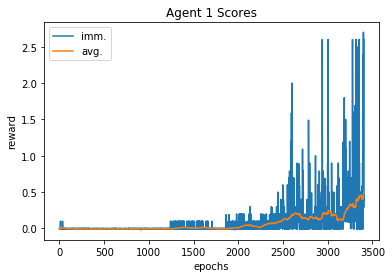

In [11]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(scores_agent1_deque_all)
plt.plot(scores_agent1_deque_avg)
plt.title('Agent 1 Scores')
plt.ylabel('reward')
plt.xlabel('epochs')
plt.legend(('imm.','avg.'))
plt.show()

In [13]:
# Play a game to check if we done well
agent_trained = DDPG_Agent(state_size=state_size * 2, action_size=action_size * 2, random_seed=0)
agent_trained.actor_local.load_state_dict(torch.load('tennis_checkpoint_actor.pth'))
agent_trained.critic_local.load_state_dict(torch.load('tennis_checkpoint_critic.pth'))
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                   # get the current state (for each agent)
scores = np.zeros(num_agents)                           # initialize the score (for each agent)
while True:
    states_cat = np.concatenate((states[0], states[1]))
    actions = agent_trained.act(states_cat, add_noise=True)
    env_info = env.step(np.reshape(actions, (2, 2)))[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    next_states_cat = np.concatenate((next_states[0], next_states[1]))
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += rewards                                  # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break